In [1]:
import dill
import os
import pickle
import random
import re
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import multiprocessing as mp
from category_encoders import TargetEncoder
from dotenv import load_dotenv
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from statsmodels.tsa.stattools import grangercausalitytests
from vega_datasets import data

In [ ]:
load_dotenv()
data_dir = os.getenv('DATA_DIR')
proj_dir = os.getenv('PROJ_DIR')

In [2]:
# constants
years = range(2000, 2021)

# Column dictionary
with open(data_dir + 'var_tables.pickle', 'rb') as f:
    [brf_dict, cov_dict] = pickle.load(f)

variable_list = list(set([v for v in brf_dict.values()]))

# Temporary variable description table
variable_desc = {
    'FRUIT_inv': 'Lack of fruit consumption',
    'PNEUMO': 'Lack of pneumonia vaccination',
    'FLUSHOT': 'Lack of flu vaccination',
    'VEGE': 'Lack of vegetable consumption',
    'RFBING': 'Whether a binge drinker',
    'SMOKER': 'Smoker category',
    'HTCARE': 'Lack of healthcare coverage',
    'SLEPTIM': 'Sleep amount',
    'RFDRHV': 'Whether a heavy drinker',
    'RFSMOK': 'Whether a current smoker',
    'TOTINDA': 'Lack of exercise',
    'FRUIT': 'Lack of fruit consumption'
}

# Load pre-processed tables for statistical analysis and visualization

In [3]:
# Refer to the preprocessing scripts/notebook to see how this table was generated
state_policies = pd.read_csv(data_dir + '../Table/state_policy_tax_spending_merge.tsv', sep='\t', low_memory=False)

print(state_policies.shape)
state_policies.head()

(1275, 40)


,year,st,aairpi,aasstpi,acorrpi,adebtpi,aedpi,aerpi,aesapi,afcgapi,...,autilpi,awtpi,w_environment_solar_taxcredit,fgastax1,icigtax,iindex,z_cigarette_taxes,cbeer,cwine,cspir
0,1995,AK,0.006273,0.066981,0.009206,0.454655,0.096609,0.020922,0.002102,0.028873,...,0.021452,0.001944,0.0,NaN,NaN,NaN,0.40,5.868462,23.850837,58.711396
1,1996,AK,0.007370,0.591879,0.009243,0.427652,0.097510,0.022406,0.001929,0.026845,...,0.019192,0.001395,0.0,NaN,NaN,NaN,0.40,5.854281,23.816396,58.484492
2,1997,AK,0.007105,0.072413,0.009034,0.425230,0.095641,0.024736,0.001797,0.026629,...,0.016321,0.001673,0.0,NaN,NaN,NaN,1.34,5.843508,21.800000,58.312130
3,1998,AK,0.006656,1.851764,0.009001,0.426553,0.087746,0.025812,0.001768,0.026040,...,0.018694,0.003588,0.0,NaN,NaN,NaN,1.31,5.836307,23.772746,58.312957
4,1999,AK,0.008067,0.058922,0.008541,0.410962,0.096329,0.023967,0.001365,0.023595,...,0.016238,0.001448,0.0,NaN,NaN,NaN,1.27,5.826317,23.748485,58.037076


In [4]:
# set variables for dev mode:
var = 'RFBING'
n_samp = '100000'

In [5]:
with open(data_dir + 'BRFSS_dataset/data_dumps/' + var + '_' + n_samp + '_peryear.pkl', 'rb') as f:
    master_table = pickle.load(f)

print(master_table.shape)
master_table.head()

(2000000, 16)


,RFBING,_STATE,_SEX,_RACE,_AGEG5YR,_BMICAT,_RFHYPE,_RFCHOL,state_abbr,year,_ASTHM,_RFHLTH,_CHLDCNT,_EDUCAG,_INCOMG,_HISPANC
79023,1.0,23,1.0,1.0,4.0,2.0,1.0,1.0,ME,2001,NaN,NaN,NaN,NaN,NaN,NaN
114947,1.0,31,2.0,1.0,4.0,2.0,1.0,1.0,NE,2001,NaN,NaN,NaN,NaN,NaN,NaN
2262,1.0,1,2.0,1.0,1.0,1.0,1.0,1.0,AL,2001,NaN,NaN,NaN,NaN,NaN,NaN
203454,1.0,56,2.0,1.0,6.0,1.0,1.0,NaN,WY,2001,NaN,NaN,NaN,NaN,NaN,NaN
107508,1.0,29,2.0,1.0,6.0,2.0,1.0,1.0,MO,2001,NaN,NaN,NaN,NaN,NaN,NaN


# Generate and load the covariate table, missing values are imputed

I've decided to use `sklearn.impute.IterativeImputer()` for this purpose

In [6]:
# If imputed table has already been saved, load it - otherwise, calculate and save
write_loc = data_dir + 'BRFSS_dataset/data_dumps/' + var + '_' + n_samp + '_dep_cov_imputed.pkl'
if os.path.exists(write_loc):
    with open(write_loc, 'rb') as f:
        data_dict = pickle.load(f)
else:
    # remove state variables, and impute missing values
    y = master_table[var]
    cols = list(set(master_table.columns).difference([var, '_STATE', 'state_abbr', 'year']))
    X = master_table[cols]
    # run standard scaling for years
    scale_year = MinMaxScaler()
    scale_year.fit(np.array(master_table['year']).reshape(-1, 1))
    X['year_scaled'] = scale_year.transform(np.array(master_table['year']).reshape(-1, 1))
    # we need imputation for missing values (nan)
    imp = IterativeImputer(max_iter=50, random_state=42)
    imp.fit(X)
    X_imput = imp.transform(X)
    scaler = StandardScaler()
    scaler.fit(X_imput)
    X_scale = scaler.transform(X_imput)
    scaler.fit(np.array(y).reshape(-1, 1))
    y_scale = scaler.transform(np.array(y).reshape(-1, 1))
    data_dict = {'X_scale': X_scale, 'y_scale': y_scale, 'cols': cols}
    with open(write_loc, 'wb') as f:
        pickle.dump(data_dict, f)

In [7]:
data_dict['master_tbl'] = master_table

print(data_dict['X_scale'].shape)
print(data_dict['y_scale'].shape)
print(data_dict['cols'])
print(data_dict['var'])
print(data_dict['n_samp'])

(2000000, 13)
(2000000, 1)
['_HISPANC', '_AGEG5YR', '_RFHLTH', '_RFHYPE', '_SEX', '_ASTHM', '_EDUCAG', '_RFCHOL', '_CHLDCNT', '_INCOMG', '_RACE', '_BMICAT']
RFBING
100000


# Covariate and Geographic visualizations, BRFSS dataset only

## covariate summary stats and visualization

In [18]:
X_scale, y_scale, cols, var, n_samp = \
    data_dict['X_scale'], data_dict['y_scale'], data_dict['cols'], data_dict['var'], data_dict['n_samp']
X_df = pd.DataFrame(X_scale)
X_df.columns = cols + ['year']
lin_model = sm.OLS(y_scale, X_df)
lin_est = lin_model.fit()
print(lin_est.summary())
result_df = pd.DataFrame({'beta': lin_est.params,
                          'abs(t)': abs(lin_est.tvalues)})\
                        .assign(cov_var=list(X_df.columns)).sort_values(by=['abs(t)'], ascending=False)
result_df.to_csv(proj_dir + 'COVDB/' + var + '_' + str(n_samp) + '_COVDB.csv', index=False)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.079
Model:                            OLS   Adj. R-squared (uncentered):              0.079
Method:                 Least Squares   F-statistic:                          1.328e+04
Date:                Thu, 18 Nov 2021   Prob (F-statistic):                        0.00
Time:                        01:15:34   Log-Likelihood:                     -2.7551e+06
No. Observations:             2000000   AIC:                                  5.510e+06
Df Residuals:                 1999987   BIC:                                  5.510e+06
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [15]:
print(result_df.shape)
result_df.head()

(13, 3)


,beta,abs(t),cov_var
_AGEG5YR,-0.255550,287.501411,_AGEG5YR
_SEX,-0.141054,202.077929,_SEX
_CHLDCNT,-0.054450,69.775157,_CHLDCNT
_RACE,-0.035568,49.703168,_RACE
year,0.033906,48.812248,year


In [50]:
def make_cov_plot(var, combined_tbl, supported_cols, title):
    base = alt.Chart(combined_tbl).mark_bar().encode(
        alt.X('cov_value:O', title='Covariate category'),
        alt.Y(f'{var}:Q', title=title)
    ).properties(
        height=300,
        width=500
    )
    # A dropdown filter
    column_dropdown = alt.binding_select(options=supported_cols)
    column_select = alt.selection_single(
        fields=['variable'],
        on='doubleclick',
        clear=False,
        bind=column_dropdown,
        name='y',
        init={'variable': '_INCOMG'}
    )
    # Final chart
    filter_columns = base.add_selection(
        column_select
    ).transform_filter(
        column_select
    )

    return filter_columns

In [51]:
# Save the altair plot to json
supported_cols = list(set(result_df.index[result_df['abs(t)'] > 10]).union(['year']))
# print(supported_cols)
sub_dfs = []
for cov in supported_cols:
    # TODO: expand to diff. types of plots, such as handling multiple categories of dep. vars:
    sub_tbl = master_table[[var, cov]].dropna().groupby(cov).agg({var: np.mean})
    sub_tbl[var] = sub_tbl[var] - 1
    sub_tbl['variable'] = cov
    sub_tbl['cov_value'] = sub_tbl.index.astype('int64')
    sub_dfs += [sub_tbl]

combined_tbl = pd.concat(sub_dfs)
COV_chart = make_cov_plot(var, combined_tbl, supported_cols, variable_desc[var])
COV_chart.save(proj_dir + 'COVDB/' + var + '_' + str(n_samp) + '_COVCHART.json')

In [52]:
COV_chart

alt.Chart(...)

In [24]:
# Aside - see if LR with the covariate table has good prediction power
y = master_table[dep_variable]
lr_model = LogisticRegression()
lr_model.fit(X_scale, y-1)
results = lr_model.predict_proba(X_scale)
print(lr_model.score(X_scale, y-1))
results = lr_model.predict_proba(X_scale)

0.7467571428571429


155151
54849


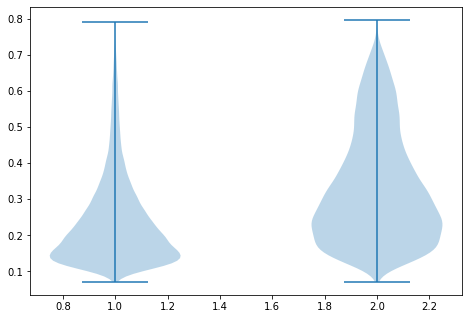

In [25]:
print(sum(y == 1))
print(sum(y == 2))
fig = plt.figure()
# Create an axes instance
ax = fig.add_axes([0,0,1,1])
# Create the boxplot
bp = ax.violinplot([results.T[1][y == 1], results.T[1][y == 2]])
plt.show()

## geographic visualizations - I will publish visualizations by state for a given dep. variable

In [25]:
# First get the residuals:
X_scale, y_scale, cols, var, n_samp, master_table = \
    data_dict['X_scale'], data_dict['y_scale'], data_dict['cols'], data_dict['var'], data_dict['n_samp'], data_dict['master_tbl']
X_df = pd.DataFrame(X_scale)
# For the geographic map, we are not including year as covariate:
X_df.columns = cols + ['year']
X_omit_year = X_df[cols]
lin_model = sm.OLS(y_scale, X_omit_year)
lin_est = lin_model.fit()
stat_df = master_table[[var, '_STATE', 'state_abbr', 'year']].assign(residual=list(lin_est.resid))
pivot_tbl = stat_df.groupby(['_STATE', 'state_abbr', 'year']).mean().reset_index()

In [26]:
pivot_tbl.head()

,_STATE,state_abbr,year,RFBING,residual
0,1,AL,2001,1.096451,-0.135509
1,1,AL,2002,1.100080,-0.092988
2,1,AL,2003,1.099057,-0.098698
3,1,AL,2004,1.097176,-0.084720
4,1,AL,2005,1.073908,-0.155530


In [27]:
min(pivot_tbl.year)

2001

In [64]:
min_year, max_year = min(pivot_tbl.year), max(pivot_tbl.year)
tbl_1 = pivot_tbl.loc[pivot_tbl.year == min_year,].drop(['year'], axis = 1)
tbl_2 = pivot_tbl.loc[pivot_tbl.year == max_year,].drop(['year'], axis = 1)
plot_df = tbl_1.merge(tbl_2, on=['_STATE', 'state_abbr'], how='outer').dropna()

In [65]:
plot_df = plot_df.assign(var_chng=lambda x: x[var+'_y'] - x[var+'_x'],
                         resid_chng=lambda x: x['residual_y'] - x['residual_x'])
plot_df.columns = ['state_id', 'state_abbr', var+'_'+str(min_year), 'resid_'+str(min_year),
                  var+'_'+str(max_year), 'resid_'+str(max_year), 'var_chng', 'resid_chng']
plot_df.to_csv(proj_dir + 'GEODB/' + var + '_' + str(n_samp) + '_GEODB.csv', index=False)

In [66]:
plot_df.head()

,state_id,state_abbr,RFBING_2001,resid_2001,RFBING_2020,resid_2020,var_chng,resid_chng
0,1,AL,1.096451,-0.135509,1.113723,-0.010262,0.017272,0.125248
1,2,AK,1.168556,0.004751,1.136364,0.020362,-0.032193,0.015611
2,4,AZ,1.138852,-0.015102,1.115856,-0.010502,-0.022996,0.004601
3,5,AR,1.090842,-0.158882,1.096197,-0.002304,0.005355,0.156578
4,6,CA,1.144950,-0.030980,1.169924,0.066163,0.024973,0.097143


In [67]:
def make_geo_plot(var, plot_df, supported_cols, title):
    states = alt.topo_feature(data.us_10m.url, 'states')

    # A dropdown filter
    column_dropdown = alt.binding_select(options=supported_cols)
    column_select = alt.selection_single(
        fields=['variable'],
        bind=column_dropdown,
        name=var,
        init={'variable': 'resid_chng'}
    )

    filter_chart = alt.Chart(states).mark_geoshape().encode(
        color='value:Q',
        tooltip = ['state_abbr:O', 'value:Q']
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(plot_df, 'state_id', ['state_abbr'] + supported_cols)
    ).transform_fold(
        supported_cols, # Preserve the State column, fold the rest
        ['variable','value']
    ).properties(
        width=500,
        height=300,
        title=title
    ).project(
        type='albersUsa'
    ).resolve_scale(
        color='independent'
    ).add_selection(
        column_select
    ).transform_filter(
        column_select
    )
    
    return filter_chart

In [68]:
supported_cols = [var+'_'+str(min_year), var+'_'+str(max_year), 'resid_chng']
GEO_chart = make_geo_plot(var, plot_df, supported_cols, variable_desc[var])
GEO_chart.save(proj_dir + 'GEODB/' + var + '_' + str(n_samp) + '_GEOCHART.json')
GEO_chart

alt.Chart(...)

## Incorporate state policies on grouped data: both original and adjusted

In [53]:
# We need to first get the residuals: we are going to use four residuals
# Just the covariates, with State-effects regressed (Leave-one-out Encoding), with time-effect regressed, and with both
# resid
# resid_t
# resid_s
# resid_ts

X_scale, y_scale, cols, var, n_samp, master_table = \
    data_dict['X_scale'], data_dict['y_scale'], data_dict['cols'], data_dict['var'], data_dict['n_samp'], data_dict['master_tbl']
X_df = pd.DataFrame(X_scale)
X_df.columns = cols + ['year']
X_covs = X_df[cols]
X_covs_t = X_df

In [55]:
# Perform target encoding on state variables
state_t = TargetEncoder()
state_t.fit(np.array(master_table['state_abbr']).reshape(-1,1),
            np.array(master_table[var]).reshape(-1,1))
X_states = state_t.transform(np.array(master_table['state_abbr']).reshape(-1,1))
scaler = StandardScaler()
X_st_scale = scaler.fit_transform(X_states)
X_covs_s = X_covs.assign(state_scale=X_st_scale)
X_covs_st = X_covs_t.assign(state_scale=X_st_scale)

quest_table = (master_table[[var, 'state_abbr', 'year']])\
    .assign(resid=sm.OLS(y_scale, X_covs).fit().resid)\
    .assign(resid_s=sm.OLS(y_scale, X_covs_s).fit().resid)\
    .assign(resid_t=sm.OLS(y_scale, X_covs_t).fit().resid)\
    .assign(resid_st=sm.OLS(y_scale, X_covs_st).fit().resid)

In [56]:
print(quest_table.shape)
quest_table.head()

(2000000, 7)


,RFBING,state_abbr,year,resid,resid_s,resid_t,resid_st
79023,1.0,ME,2001,-0.679971,-0.657923,-0.629058,-0.610474
114947,1.0,NE,2001,-0.364446,-0.351493,-0.321332,-0.311219
2262,1.0,AL,2001,-0.290500,-0.477989,-0.240688,-0.428151
203454,1.0,WY,2001,-0.548722,-0.601986,-0.505186,-0.560234
107508,1.0,MO,2001,-0.126627,-0.112575,-0.073786,-0.063184


In [57]:
pivot_table = quest_table.groupby(['state_abbr', 'year']).mean()
pivot_table = pivot_table.merge(right = state_policies, left_on = ['state_abbr', 'year'],
                                right_on = ['st', 'year'], how = 'left')
pivot_table = pivot_table.loc[~pd.isna(pivot_table['st']),]

In [58]:
print(pivot_table.shape)
pivot_table.head()

(967, 45)


,RFBING,year,resid,resid_s,resid_t,resid_st,st,aairpi,aasstpi,acorrpi,...,autilpi,awtpi,w_environment_solar_taxcredit,fgastax1,icigtax,iindex,z_cigarette_taxes,cbeer,cwine,cspir
0,1.168556,2001,-0.095611,-0.090175,-0.042761,-0.040635,AK,0.007856,1.003636,0.008723,...,0.015403,0.001649,0.0,0.08,NaN,NaN,1.18,6.198329,23.683357,57.608000
1,1.185047,2002,-0.075828,-0.074612,-0.022919,-0.024949,AK,0.008134,1.589654,0.008252,...,0.013631,0.001357,0.0,0.08,NaN,NaN,1.15,7.374568,27.291982,73.318946
2,1.184133,2003,-0.079300,-0.075866,-0.026435,-0.026280,AK,0.009959,1.569347,0.007992,...,0.014121,0.001626,0.0,0.08,NaN,NaN,1.11,7.346034,27.225313,72.977600
3,1.170759,2004,-0.066051,-0.066760,-0.013479,-0.017382,AK,0.011783,1.549040,0.007731,...,0.014610,0.001894,0.0,0.08,NaN,NaN,1.05,7.313556,27.149431,72.589086
4,1.159178,2005,-0.110825,-0.112023,-0.057998,-0.062397,AK,0.003036,1.555538,0.008207,...,0.014737,0.002127,0.0,0.08,NaN,NaN,1.59,7.273591,27.056055,72.111001


In [61]:
col = 'resid_st'
test_table = pivot_table.loc[~pd.isna(pivot_table[col]),]
test_cols = test_table.columns[7:]

# Try first without multiprocessing
def get_tstat(test_col):
    return sm.OLS(test_table[col], test_table[test_col], missing='drop').fit()

test_models = list(map(get_tstat, test_cols))
result_df = pd.DataFrame({'beta': [model.params[0] for model in test_models],
                          'abs(t)': [abs(model.tvalues[0]) for model in test_models],
                          'pvalue':[model.pvalues[0] for model in test_models]}).sort_values(by=['pvalue'])
result_df = result_df.assign(indep=list(test_cols[result_df.index]))
result_df.to_csv(proj_dir + 'CORRDB/' + var + '_' + str(n_samp) + '_CORRDB.csv', index=False)

In [62]:
test_table.head()

,RFBING,year,resid,resid_s,resid_t,resid_st,st,aairpi,aasstpi,acorrpi,...,autilpi,awtpi,w_environment_solar_taxcredit,fgastax1,icigtax,iindex,z_cigarette_taxes,cbeer,cwine,cspir
0,1.168556,2001,-0.095611,-0.090175,-0.042761,-0.040635,AK,0.007856,1.003636,0.008723,...,0.015403,0.001649,0.0,0.08,NaN,NaN,1.18,6.198329,23.683357,57.608000
1,1.185047,2002,-0.075828,-0.074612,-0.022919,-0.024949,AK,0.008134,1.589654,0.008252,...,0.013631,0.001357,0.0,0.08,NaN,NaN,1.15,7.374568,27.291982,73.318946
2,1.184133,2003,-0.079300,-0.075866,-0.026435,-0.026280,AK,0.009959,1.569347,0.007992,...,0.014121,0.001626,0.0,0.08,NaN,NaN,1.11,7.346034,27.225313,72.977600
3,1.170759,2004,-0.066051,-0.066760,-0.013479,-0.017382,AK,0.011783,1.549040,0.007731,...,0.014610,0.001894,0.0,0.08,NaN,NaN,1.05,7.313556,27.149431,72.589086
4,1.159178,2005,-0.110825,-0.112023,-0.057998,-0.062397,AK,0.003036,1.555538,0.008207,...,0.014737,0.002127,0.0,0.08,NaN,NaN,1.59,7.273591,27.056055,72.111001


In [63]:
result_df.head()

,beta,abs(t),pvalue,indep
37,-0.000091,5.405506,8.144349e-08,cspir
35,-0.000887,5.287978,1.529737e-07,cbeer
36,-0.000207,5.176607,2.748718e-07,cwine
14,-0.082118,5.079701,4.650426e-07,aincstat3
11,-0.259869,5.011480,6.747099e-07,ahealpi


In [69]:
supported_cols = list(result_df.indep[:5])
sub_dfs = []
for indep in supported_cols:
    # TODO: expand to diff. types of plots, such as handling multiple categories of dep. vars:
    sub_tbl = test_table[['st', 'year', 'resid_st']].assign(variable=indep).assign(var_value=test_table[indep])
    sub_dfs += [sub_tbl]

combined_tbl = pd.concat(sub_dfs)
combined_tbl.columns = ['st', 'year', var, 'variable', 'var_value']

In [70]:
combined_tbl

,st,year,RFBING,variable,var_value
0,AK,2001,-0.040635,cspir,57.608000
1,AK,2002,-0.024949,cspir,73.318946
2,AK,2003,-0.026280,cspir,72.977600
3,AK,2004,-0.017382,cspir,72.589086
4,AK,2005,-0.062397,cspir,72.111001
...,...,...,...,...,...
1060,WY,2015,-0.023803,ahealpi,0.043355
1061,WY,2016,-0.053100,ahealpi,NaN
1062,WY,2017,-0.030039,ahealpi,NaN
1063,WY,2018,-0.038979,ahealpi,NaN


In [71]:
def make_corr_plot(var, combined_tbl, supported_cols, title):
    # dropdown filter
    column_dropdown = alt.binding_select(options=supported_cols)
    column_select = alt.selection_single(
        fields=['variable'],
        on='doubleclick',
        clear=False,
        bind=column_dropdown,
        name='x'
    )

    points = alt.Chart(combined_tbl).mark_point().encode(
        alt.X('var_value:Q', title='Independent variable value'),
        alt.Y(f'{var}:Q', title=title),
        color='year:O',
        tooltip=['st:N', 'year:O']
    )
    line = points.transform_regression('var_value', f'{var}').mark_line()

    combined = points+line
    combined = combined.properties(
        height=300,
        width=450
    ).add_selection(
        column_select
    ).transform_filter(
        column_select
    )

    return combined

In [72]:
make_corr_plot(var, combined_tbl, supported_cols, variable_desc[var])

alt.LayerChart(...)

## Time series analysis for a given state and variable with Granger causality

For this portion, a full scan is going to be followed by manual curation

In [10]:
# We need to first get the residuals: we are going to use four residuals
# Just the covariates, with State-effects regressed (Leave-one-out Encoding), with time-effect regressed, and with both
# resid
# resid_t
# resid_s
# resid_ts

X_scale, y_scale, cols, var, n_samp, master_table = \
    data_dict['X_scale'], data_dict['y_scale'], data_dict['cols'], data_dict['var'], data_dict['n_samp'], data_dict['master_tbl']
X_df = pd.DataFrame(X_scale)
X_df.columns = cols + ['year']
X_covs = X_df[cols]

In [11]:
quest_table = (master_table[[var, 'state_abbr', 'year']])\
    .assign(resid=sm.OLS(y_scale, X_covs).fit().resid)

In [13]:
print(quest_table.shape)
quest_table.head()

(2000000, 4)


,RFBING,state_abbr,year,resid
79023,1.0,ME,2001,-0.679971
114947,1.0,NE,2001,-0.364446
2262,1.0,AL,2001,-0.290500
203454,1.0,WY,2001,-0.548722
107508,1.0,MO,2001,-0.126627


In [84]:
pivot_table = quest_table.groupby(['state_abbr', 'year']).mean()
pivot_table = pivot_table.reset_index()
pivot_table.year = pivot_table.year+1
pivot_table = pivot_table.merge(right = state_policies, left_on = ['state_abbr', 'year'],
                                right_on = ['st', 'year'], how = 'left')
pivot_table = pivot_table.loc[~pd.isna(pivot_table['state_abbr']),]
# state policy data quality is really bad after 2015: cut off data until this year
pivot_table = pivot_table.loc[pivot_table.year<=2015,]

In [85]:
print(pivot_table.shape)
pivot_table.head()

(748, 43)


,state_abbr,year,RFBING,resid,st,aairpi,aasstpi,acorrpi,adebtpi,aedpi,...,autilpi,awtpi,w_environment_solar_taxcredit,fgastax1,icigtax,iindex,z_cigarette_taxes,cbeer,cwine,cspir
0,AK,2002,1.168556,-0.095611,AK,0.008134,1.589654,0.008252,0.407054,0.099189,...,0.013631,0.001357,0.0,0.08,NaN,NaN,1.15,7.374568,27.291982,73.318946
1,AK,2003,1.185047,-0.075828,AK,0.009959,1.569347,0.007992,0.389729,0.099472,...,0.014121,0.001626,0.0,0.08,NaN,NaN,1.11,7.346034,27.225313,72.977600
2,AK,2004,1.184133,-0.079300,AK,0.011783,1.549040,0.007731,0.372404,0.099756,...,0.014610,0.001894,0.0,0.08,NaN,NaN,1.05,7.313556,27.149431,72.589086
3,AK,2005,1.170759,-0.066051,AK,0.003036,1.555538,0.008207,0.362159,0.097640,...,0.014737,0.002127,0.0,0.08,NaN,NaN,1.59,7.273591,27.056055,72.111001
4,AK,2006,1.159178,-0.110825,AK,0.002999,1.620382,0.008235,0.366977,0.095403,...,0.015821,0.002446,0.0,0.08,2.11625,-0.296175,1.52,7.236729,26.969928,71.670032


In [42]:
gc_model = grangercausalitytests(
    pd.concat([pd.Series(np.diff(sub_tbl[dep_variable])), pd.Series(np.diff(sub_tbl[indep_variable]))], axis = 1), 3
);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7581  , p=0.0373  , df_denom=10, df_num=1
ssr based chi2 test:   chi2=7.4855  , p=0.0062  , df=1
likelihood ratio test: chi2=5.9120  , p=0.0150  , df=1
parameter F test:         F=5.7581  , p=0.0373  , df_denom=10, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2704  , p=0.1738  , df_denom=7, df_num=2
ssr based chi2 test:   chi2=7.7842  , p=0.0204  , df=2
likelihood ratio test: chi2=5.9997  , p=0.0498  , df=2
parameter F test:         F=2.2704  , p=0.1738  , df_denom=7, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7657  , p=0.1754  , df_denom=4, df_num=3
ssr based chi2 test:   chi2=22.8174 , p=0.0000  , df=3
likelihood ratio test: chi2=12.3539 , p=0.0063  , df=3
parameter F test:         F=2.7657  , p=0.1754  , df_denom=4, df_num=3


In [83]:
n_lag = 3
dep_variable = 'RFBING'
indep_variable = 'cbeer'
for state in pd.unique(pivot_table['state_abbr']):
    sub_tbl = pivot_table.query(f'state_abbr == "{state}"')
    if sub_tbl.shape[0] > 0:
        sub_tbl = sub_tbl.query(indep_variable+' > 0')
        query_tbl = pd.concat([pd.Series(np.diff(sub_tbl[dep_variable])), pd.Series(np.diff(sub_tbl[indep_variable]))], axis = 1)
        if len(pd.unique(query_tbl.iloc[:,1])) > 1:
            try:
                gc_model = grangercausalitytests(query_tbl, n_lag, verbose = False)
            except:
                continue
            if np.any([gc_model[x+1][0]['ssr_ftest'][1] < 0.05 for x in range(n_lag)]):
                print(state)
                print([gc_model[x+1][0]['ssr_ftest'][1] for x in range(n_lag)])

AL
[0.24019250552285018, 0.5587054157042564, 0.011230567293651416]
CO
[0.5668301243464955, 0.6022159155338628, 0.03338703916920182]
CT
[0.015125086136792238, 0.1151024090553046, 0.2461665876446448]
IA
[0.2994410135286466, 0.7170146062662763, 0.006677122992916186]
MT
[0.9055130507439926, 0.9678753098361821, 0.047018128481694545]
NJ
[0.9898870508441994, 0.9612433835161504, 0.04550917626022197]
WI
[0.82876837953377, 0.8131314278460474, 0.03045554637698203]


In [ ]:
dep_variable = 'RFBING'
test_cols = pivot_table.columns[5:]
n_lag = 3

combined_dict = {}
for indep_variable in test_cols:
    count = 0
    state_list = []
    pval_list = []
    lag_list = []
    for state in pd.unique(pivot_table['state_abbr']):
        sub_tbl = pivot_table.query(f'state_abbr == "{state}"')
        if sub_tbl.shape[0] > 0:
            sub_tbl = sub_tbl.query(indep_variable+' > 0')
            query_tbl = pd.concat([pd.Series(np.diff(sub_tbl[dep_variable])), pd.Series(np.diff(sub_tbl[indep_variable]))], axis = 1)
            if len(pd.unique(query_tbl.iloc[:,1])) > 1:
                try:
                    gc_model = grangercausalitytests(query_tbl, n_lag, verbose = False)
                except:
                    continue
                pvals = [gc_model[x+1][0]['ssr_ftest'][1] for x in range(n_lag)]
                if np.any([pval < 0.05 for pval in pvals]):
                    count+=1
                    state_list.append(state)
                    lag = int(np.where(pvals == min(pvals))[0])
                    lag_list.append(lag)
                    pval_list.append(pvals[lag])
    combined_dict[indep_variable] = {'count': count, 'state_list': state_list, 'pval_list': pval_list, 'lag_list': lag_list}

In [172]:
combined_dict

{'aairpi': {'count': 7,
  'state_list': ['GA', 'HI', 'LA', 'NM', 'OR', 'TN', 'VT'],
  'pval_list': [0.006001321793379111,
   0.012279596674622055,
   0.029279852303756192,
   0.011263478737061688,
   0.03748105487333815,
   0.015285074595400145,
   0.022367721288728923],
  'lag_list': [1, 0, 1, 0, 0, 1, 0]},
 'aasstpi': {'count': 6,
  'state_list': ['CT', 'LA', 'MI', 'NY', 'OK', 'VA'],
  'pval_list': [0.03399876948225202,
   0.03809116021209866,
   0.04488796552546041,
   0.004214173775817969,
   0.016718753939827784,
   0.022004653920268423],
  'lag_list': [1, 2, 0, 2, 1, 1]},
 'acorrpi': {'count': 5,
  'state_list': ['AZ', 'HI', 'LA', 'MO', 'TN'],
  'pval_list': [0.00026464382001526333,
   0.046875644358265064,
   0.0324398816579064,
   0.029828689576503482,
   0.04829421919607598],
  'lag_list': [0, 1, 0, 0, 0]},
 'adebtpi': {'count': 4,
  'state_list': ['CO', 'MI', 'RI', 'WY'],
  'pval_list': [0.020558244492859163,
   0.031973732012599065,
   0.04387774888255494,
   0.0295315562174

In [96]:
top_vars = sorted(list(test_cols), key=(lambda x: combined_dict[x]['count']), reverse=True)[:10]

In [103]:
from collections import namedtuple
Row = namedtuple('Row', ['indep', 'count', 'state', 'minPval', 'lag'])

In [104]:
db_data = []
for top_var in top_vars:
    index = combined_dict[top_var]
    if index['count'] > 0:
        min_val = min(index['pval_list'])
        ind = int(np.where(min_val == min(index['pval_list']))[0])
        db_data.append(Row(top_var, index['count'], index['state_list'][ind], index['pval_list'][ind], index['lag_list'][ind]))

In [106]:
DB_df = pd.DataFrame(db_data)
DB_df.to_csv(proj_dir + 'TSDB/' + var + '_' + str(n_samp) + '_TSDB.csv', index=False)

In [138]:
list(sub_tbl['year']) + list(sub_tbl['year'])

[2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015]

In [170]:
# construct plot_df
plot_list = []
var_target = 'aedpi'
for row in db_data:
    if row[0] == var_target:
        break
state = row[2]
sub_tbl = pivot_table.query(f'state_abbr == "{state}"')[['year', dep_variable, var_target]]

In [174]:
base = alt.Chart(sub_tbl).encode(
    alt.X('year:O', title='Year')
).properties(
    height=300,
    width=450
)
l1 = base.mark_line(color='#57A44C').encode(
    alt.Y(f'{var_target}:Q', scale=alt.Scale(domain=[min(sub_tbl[var_target]), max(sub_tbl[var_target])])),
    tooltip = ['year:O', f'{var_target}:Q']
)
l2 = base.mark_line(color='#5276A7').encode(
    alt.Y(f'{dep_variable}:Q', scale=alt.Scale(domain=[min(sub_tbl[dep_variable]), max(sub_tbl[dep_variable])])),
    tooltip = ['year:O', f'{dep_variable}:Q']
)
combined = alt.layer(l1, l2).resolve_scale(
    y = 'independent'
)

In [176]:
def make_ts_plot(sub_tbl, dep_variable, var_target, title):
    base = alt.Chart(sub_tbl).encode(
        alt.X('year:O', title='Year')
    ).properties(
        height=300,
        width=450
    )
    l1 = base.mark_line(color='#57A44C').encode(
        alt.Y(f'{var_target}:Q', scale=alt.Scale(domain=[min(sub_tbl[var_target]), max(sub_tbl[var_target])])),
        tooltip=['year:O', f'{var_target}:Q']
    )
    l2 = base.mark_line(color='#5276A7').encode(
        alt.Y(f'{dep_variable}:Q', title=title,
              scale=alt.Scale(domain=[min(sub_tbl[dep_variable]), max(sub_tbl[dep_variable])])),
        tooltip=['year:O', f'{dep_variable}:Q']
    )
    combined = alt.layer(l1, l2).resolve_scale(
        y='independent'
    )

    return combined

In [181]:
dep_variable

'RFBING'

In [182]:
var_target

'aedpi'

In [183]:
make_ts_plot(sub_tbl, dep_variable, var_target, variable_desc[dep_variable])

alt.LayerChart(...)